In [1]:
import os, gc, pickle, copy, datetime, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
pd.set_option('display.max_columns', 100) # 表示できる列数
warnings.filterwarnings('ignore')

# Data loading

In [2]:
df_train = pd.read_csv("../input/covid19-global-forecasting-week-1/train.csv")
print(df_train.shape)
df_train.head()

(17892, 8)


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [3]:
df_test = pd.read_csv("../input/covid19-global-forecasting-week-1/test.csv")
print(df_test.shape)
df_test.head()

(12212, 6)


,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


### Preprocessing

In [4]:
# concat train and test
df_traintest = pd.concat([df_train, df_test])
print(df_train.shape, df_test.shape, df_traintest.shape)

(17892, 8) (12212, 6) (30104, 9)


In [5]:
# concat Country/Region and Province/State
def func(x):
    try:
        x_new = x['Country/Region'] + "/" + x['Province/State']
    except:
        x_new = x['Country/Region']
    return x_new
        
df_traintest['place_id'] = df_traintest.apply(lambda x: func(x), axis=1)
tmp = np.sort(df_traintest['place_id'].unique())
print("num unique places: {}".format(len(tmp)))
print(tmp[:10])

num unique places: 284
['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Australia/Australian Capital Territory'
 'Australia/From Diamond Princess']


In [6]:
# get place list
places = np.sort(df_traintest['place_id'].unique())

In [7]:
# process date
df_traintest['Date'] = pd.to_datetime(df_traintest['Date'])
df_traintest['day'] = df_traintest['Date'].apply(lambda x: x.dayofyear).astype(np.int16)
df_traintest.head()

,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day
0,0.0,Afghanistan,2020-01-22,0.0,NaN,1.0,33.0,65.0,NaN,Afghanistan,22
1,0.0,Afghanistan,2020-01-23,0.0,NaN,2.0,33.0,65.0,NaN,Afghanistan,23
2,0.0,Afghanistan,2020-01-24,0.0,NaN,3.0,33.0,65.0,NaN,Afghanistan,24
3,0.0,Afghanistan,2020-01-25,0.0,NaN,4.0,33.0,65.0,NaN,Afghanistan,25
4,0.0,Afghanistan,2020-01-26,0.0,NaN,5.0,33.0,65.0,NaN,Afghanistan,26


In [8]:
# calc cases, fatalities, recover per day
df_traintest2 = copy.deepcopy(df_traintest)
df_traintest2['cases/day'] = 0
df_traintest2['fatal/day'] = 0
tmp_list = np.zeros(len(df_traintest2))
for place in places:
    tmp = df_traintest2['ConfirmedCases'][df_traintest2['place_id']==place].values
    tmp[1:] -= tmp[:-1]
    df_traintest2['cases/day'][df_traintest2['place_id']==place] = tmp
    tmp = df_traintest2['Fatalities'][df_traintest2['place_id']==place].values
    tmp[1:] -= tmp[:-1]
    df_traintest2['fatal/day'][df_traintest2['place_id']==place] = tmp
print(df_traintest2.shape)
df_traintest2[df_traintest2['place_id']=='China/Hubei'].head()

(30104, 13)


,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day
3780,444.0,China,2020-01-22,17.0,NaN,5581.0,30.9756,112.2707,Hubei,China/Hubei,22,444,17
3781,444.0,China,2020-01-23,17.0,NaN,5582.0,30.9756,112.2707,Hubei,China/Hubei,23,0,0
3782,549.0,China,2020-01-24,24.0,NaN,5583.0,30.9756,112.2707,Hubei,China/Hubei,24,105,7
3783,761.0,China,2020-01-25,40.0,NaN,5584.0,30.9756,112.2707,Hubei,China/Hubei,25,212,16
3784,1058.0,China,2020-01-26,52.0,NaN,5585.0,30.9756,112.2707,Hubei,China/Hubei,26,297,12


In [9]:
# aggregate cases and fatalities
def do_aggregation(df, col, mean_range):
    df_new = copy.deepcopy(df)
    col_new = '{}_({}-{})'.format(col, mean_range[0], mean_range[1])
    df_new[col_new] = 0
    tmp = df_new[col].rolling(mean_range[1]-mean_range[0]+1).mean()
    df_new[col_new][mean_range[0]:] = tmp[:-(mean_range[0])]
    df_new[col_new][pd.isna(df_new[col_new])] = 0
    return df_new[[col_new]].reset_index(drop=True)

def do_aggregations(df):
    df = pd.concat([df, do_aggregation(df, 'cases/day', [1,1]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'cases/day', [1,7]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'cases/day', [8,14]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'cases/day', [15,21]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'fatal/day', [1,1]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'fatal/day', [1,7]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'fatal/day', [8,14]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'fatal/day', [15,21]).reset_index(drop=True)], axis=1)
    for threshold in [1, 10, 100]:
        days_under_threshold = (df['ConfirmedCases']<threshold).sum()
        tmp = df['day'].values - 22 - days_under_threshold
        tmp[tmp<=0] = 0
        df['days_since_{}cases'.format(threshold)] = tmp
            
    for threshold in [1, 10, 100]:
        days_under_threshold = (df['Fatalities']<threshold).sum()
        tmp = df['day'].values - 22 - days_under_threshold
        tmp[tmp<=0] = 0
        df['days_since_{}fatal'.format(threshold)] = tmp
    
    # process China/Hubei
    if df['place_id'][0]=='China/Hubei':
        df['days_since_1cases'] += 35 # 2019/12/8
        df['days_since_10cases'] += 35-13 # 2019/12/8-2020/1/2 assume 2019/12/8+13
        df['days_since_100cases'] += 4 # 2020/1/18
        df['days_since_1fatal'] += 13 # 2020/1/9
    return df

In [10]:
df_traintest3 = []
for place in places[:]:
    df_tmp = df_traintest2[df_traintest2['place_id']==place].reset_index(drop=True)
    df_tmp = do_aggregations(df_tmp)
    df_traintest3.append(df_tmp)
df_traintest3 = pd.concat(df_traintest3).reset_index(drop=True)
df_traintest3[df_traintest3['place_id']=='China/Hubei'].head()

,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day,cases/day_(1-1),cases/day_(1-7),cases/day_(8-14),cases/day_(15-21),fatal/day_(1-1),fatal/day_(1-7),fatal/day_(8-14),fatal/day_(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal
6360,444.0,China,2020-01-22,17.0,NaN,5581.0,30.9756,112.2707,Hubei,China/Hubei,22,444,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,22,4,13,0,0
6361,444.0,China,2020-01-23,17.0,NaN,5582.0,30.9756,112.2707,Hubei,China/Hubei,23,0,0,444.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,36,23,5,14,1,0
6362,549.0,China,2020-01-24,24.0,NaN,5583.0,30.9756,112.2707,Hubei,China/Hubei,24,105,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,24,6,15,2,0
6363,761.0,China,2020-01-25,40.0,NaN,5584.0,30.9756,112.2707,Hubei,China/Hubei,25,212,16,105.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,38,25,7,16,3,0
6364,1058.0,China,2020-01-26,52.0,NaN,5585.0,30.9756,112.2707,Hubei,China/Hubei,26,297,12,212.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,39,26,8,17,4,0


In [11]:
# add Smoking rate per country
# data of smoking rate is obtained from https://ourworldindata.org/smoking
df_smoking = pd.read_csv("../input/smokingstats/share-of-adults-who-smoke.csv")
print(np.sort(df_smoking['Entity'].unique())[:10])
df_smoking.head()

['Albania' 'Algeria' 'Andorra' 'Arab World' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas']


,Entity,Code,Year,"Smoking prevalence, total (ages 15+) (% of adults)"
0,Albania,ALB,2000,34.8
1,Albania,ALB,2005,32.7
2,Albania,ALB,2010,31.2
3,Albania,ALB,2011,30.7
4,Albania,ALB,2012,30.2


In [12]:
# extract newest data
df_smoking_recent = df_smoking.sort_values('Year', ascending=False).reset_index(drop=True)
df_smoking_recent = df_smoking_recent[df_smoking_recent['Entity'].duplicated()==False]
df_smoking_recent['Country/Region'] = df_smoking_recent['Entity']
df_smoking_recent['SmokingRate'] = df_smoking_recent['Smoking prevalence, total (ages 15+) (% of adults)']
df_smoking_recent.head()

,Entity,Code,Year,"Smoking prevalence, total (ages 15+) (% of adults)",Country/Region,SmokingRate
0,Zimbabwe,ZWE,2016,15.8,Zimbabwe,15.8
1,Namibia,NAM,2016,21.4,Namibia,21.4
2,Suriname,SUR,2016,25.0,Suriname,25.0
3,Morocco,MAR,2016,23.4,Morocco,23.4
4,India,IND,2016,11.5,India,11.5


In [13]:
# merge
df_traintest4 = pd.merge(df_traintest3, df_smoking_recent[['Country/Region', 'SmokingRate']], on='Country/Region', how='left')
print(df_traintest4.shape)
df_traintest4.head()

(30104, 28)


,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day,cases/day_(1-1),cases/day_(1-7),cases/day_(8-14),cases/day_(15-21),fatal/day_(1-1),fatal/day_(1-7),fatal/day_(8-14),fatal/day_(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate
0,0.0,Afghanistan,2020-01-22,0.0,NaN,1.0,33.0,65.0,NaN,Afghanistan,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN
1,0.0,Afghanistan,2020-01-23,0.0,NaN,2.0,33.0,65.0,NaN,Afghanistan,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN
2,0.0,Afghanistan,2020-01-24,0.0,NaN,3.0,33.0,65.0,NaN,Afghanistan,24,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN
3,0.0,Afghanistan,2020-01-25,0.0,NaN,4.0,33.0,65.0,NaN,Afghanistan,25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN
4,0.0,Afghanistan,2020-01-26,0.0,NaN,5.0,33.0,65.0,NaN,Afghanistan,26,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN


In [14]:
# fill na with world smoking rate
SmokingRate = df_smoking_recent['SmokingRate'][df_smoking_recent['Entity']=='World'].values[0]
print("Smoking rate of the world: {:.6f}".format(SmokingRate))
df_traintest4['SmokingRate'][pd.isna(df_traintest4['SmokingRate'])] = SmokingRate
df_traintest4.head()

Smoking rate of the world: 20.475517


,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day,cases/day_(1-1),cases/day_(1-7),cases/day_(8-14),cases/day_(15-21),fatal/day_(1-1),fatal/day_(1-7),fatal/day_(8-14),fatal/day_(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate
0,0.0,Afghanistan,2020-01-22,0.0,NaN,1.0,33.0,65.0,NaN,Afghanistan,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517
1,0.0,Afghanistan,2020-01-23,0.0,NaN,2.0,33.0,65.0,NaN,Afghanistan,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517
2,0.0,Afghanistan,2020-01-24,0.0,NaN,3.0,33.0,65.0,NaN,Afghanistan,24,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517
3,0.0,Afghanistan,2020-01-25,0.0,NaN,4.0,33.0,65.0,NaN,Afghanistan,25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517
4,0.0,Afghanistan,2020-01-26,0.0,NaN,5.0,33.0,65.0,NaN,Afghanistan,26,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517


In [15]:
# add data from World Economic Outlook Database
# https://www.imf.org/external/pubs/ft/weo/2017/01/weodata/index.aspx
df_weo = pd.read_csv("../input/smokingstats/WEO.csv")
df_weo.head()

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,2016,2017,2018,2019,2020,2021,2022,Estimates Start After
0,Afghanistan,"Gross domestic product, constant prices",National currency,Billions,Source: National Statistics Office Latest actu...,467.035,476.376,490.667,507.84,528.154,551.921,579.517,611.39,2014.0
1,Afghanistan,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",0.758,2,3,3.5,4,4.5,5,5.5,2014.0
2,Afghanistan,"Gross domestic product, current prices",National currency,Billions,Source: National Statistics Office Latest actu...,"1,203.67","1,281.66","1,399.43","1,535.31","1,692.57","1,874.47","2,085.38","2,330.54",2014.0
3,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",19.687,18.886,20.57,21.706,23.233,24.93,26.857,29.113,2014.0
4,Afghanistan,"Gross domestic product, deflator",Index,NaN,"See notes for: Gross domestic product, consta...",257.726,269.044,285.209,302.321,320.469,339.627,359.848,381.188,2014.0


In [16]:
print(df_weo['Subject Descriptor'].unique())

['Gross domestic product, constant prices'
 'Gross domestic product, current prices'
 'Gross domestic product, deflator'
 'Gross domestic product per capita, constant prices'
 'Gross domestic product per capita, current prices'
 'Output gap in percent of potential GDP'
 'Gross domestic product based on purchasing-power-parity (PPP) valuation of country GDP'
 'Gross domestic product based on purchasing-power-parity (PPP) per capita GDP'
 'Gross domestic product based on purchasing-power-parity (PPP) share of world total'
 'Implied PPP conversion rate' 'Total investment' 'Gross national savings'
 'Inflation, average consumer prices'
 'Inflation, end of period consumer prices'
 'Six-month London interbank offered rate (LIBOR)'
 'Volume of imports of goods and services' 'Volume of Imports of goods'
 'Volume of exports of goods and services' 'Volume of exports of goods'
 'Unemployment rate' 'Employment' 'Population'
 'General government revenue' 'General government total expenditure'
 'Gene

In [17]:
subs  = df_weo['Subject Descriptor'].unique()[:-1]
df_weo_agg = df_weo[['Country']][df_weo['Country'].duplicated()==False].reset_index(drop=True)
for sub in subs[:]:
    df_tmp = df_weo[['Country', '2019']][df_weo['Subject Descriptor']==sub].reset_index(drop=True)
    df_tmp = df_tmp[df_tmp['Country'].duplicated()==False].reset_index(drop=True)
    df_tmp.columns = ['Country', sub]
    df_weo_agg = df_weo_agg.merge(df_tmp, on='Country', how='left')
df_weo_agg.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_weo_agg.columns]
df_weo_agg.columns
df_weo_agg['Country/Region'] = df_weo_agg['Country']
df_weo_agg.head()

,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,Country/Region
0,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,Afghanistan
1,Albania,858.595,"1,841.87",214.522,"299,027.69","641,479.81",NaN,40.999,"14,278.81",0.029,44.925,26.646,14.854,130.977,132.641,NaN,2.479,0.836,4.043,4.242,15.35,NaN,2.871,492.277,537.234,-44.957,NaN,-6.302,"1,113.30","1,113.30","1,841.87",-1.632,Albania
2,Algeria,"7,583.96","21,125.43",278.554,"176,011.62","490,287.91",NaN,675.691,"15,681.72",0.475,31.265,38.873,29.337,208.827,211.975,NaN,-2.309,-2.309,1.649,1.79,14.521,NaN,43.088,"6,365.52","6,550.00",-184.478,NaN,-287.307,"3,710.77","3,710.77","21,125.43",-17.345,Algeria
3,Angola,"1,760.49","27,359.28","1,554.07","58,886.08","915,131.64",NaN,208.583,"6,976.84",0.147,131.167,7.284,3.555,337.704,355.519,NaN,1.543,1.556,0.424,0.186,NaN,NaN,29.897,"5,304.57","6,265.99",-961.422,NaN,-54.413,NaN,"17,195.39","27,359.28",-5.153,Angola
4,Antigua and Barbuda,2.919,4.26,145.942,"31,317.40","45,705.31",NaN,2.563,"27,500.00",0.002,1.662,NaN,15.336,143.235,144.893,NaN,0.777,1.7,2.386,1.665,NaN,NaN,0.093,0.921,0.905,0.017,NaN,0.126,NaN,3.595,4.26,-0.152,Antigua and Barbuda


In [18]:
# merge
df_traintest5 = pd.merge(df_traintest4, df_weo_agg, on='Country/Region', how='left')
print(df_traintest5.shape)
df_traintest5.head()

(30104, 60)


,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day,cases/day_(1-1),cases/day_(1-7),cases/day_(8-14),cases/day_(15-21),fatal/day_(1-1),fatal/day_(1-7),fatal/day_(8-14),fatal/day_(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance
0,0.0,Afghanistan,2020-01-22,0.0,NaN,1.0,33.0,65.0,NaN,Afghanistan,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425
1,0.0,Afghanistan,2020-01-23,0.0,NaN,2.0,33.0,65.0,NaN,Afghanistan,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425
2,0.0,Afghanistan,2020-01-24,0.0,NaN,3.0,33.0,65.0,NaN,Afghanistan,24,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425
3,0.0,Afghanistan,2020-01-25,0.0,NaN,4.0,33.0,65.0,NaN,Afghanistan,25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425
4,0.0,Afghanistan,2020-01-26,0.0,NaN,5.0,33.0,65.0,NaN,Afghanistan,26,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425


In [19]:
# add Life expectancy
# Life expectancy at birth obtained from http://hdr.undp.org/en/data
df_life = pd.read_csv("../input/smokingstats/Life expectancy at birth.csv")
tmp = df_life.iloc[:,1].values.tolist()
df_life = df_life[['Country', '2018']]
def func(x):
    x_new = 0
    try:
        x_new = float(x.replace(",", ""))
    except:
#         print(x)
        x_new = np.nan
    return x_new
    
df_life['2018'] = df_life['2018'].apply(lambda x: func(x))
df_life.head()

,Country,2018
0,Afghanistan,64.5
1,Albania,78.5
2,Algeria,76.7
3,Andorra,81.8
4,Angola,60.8


In [20]:
df_life = df_life[['Country', '2018']]
df_life.columns = ['Country/Region', 'LifeExpectancy']

In [21]:
# merge
df_traintest6 = pd.merge(df_traintest5, df_life, on='Country/Region', how='left')
print(len(df_traintest6))
df_traintest6.head()

30104


,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day,cases/day_(1-1),cases/day_(1-7),cases/day_(8-14),cases/day_(15-21),fatal/day_(1-1),fatal/day_(1-7),fatal/day_(8-14),fatal/day_(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy
0,0.0,Afghanistan,2020-01-22,0.0,NaN,1.0,33.0,65.0,NaN,Afghanistan,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5
1,0.0,Afghanistan,2020-01-23,0.0,NaN,2.0,33.0,65.0,NaN,Afghanistan,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5
2,0.0,Afghanistan,2020-01-24,0.0,NaN,3.0,33.0,65.0,NaN,Afghanistan,24,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5
3,0.0,Afghanistan,2020-01-25,0.0,NaN,4.0,33.0,65.0,NaN,Afghanistan,25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5
4,0.0,Afghanistan,2020-01-26,0.0,NaN,5.0,33.0,65.0,NaN,Afghanistan,26,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5


In [22]:
# add additional info from countryinfo dataset
df_country = pd.read_csv("../input/countryinfo/covid19countryinfo.csv")
df_country.head()

,country,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,restrictions,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung
0,Afghanistan,"38,928,346",NaN,NaN,60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33
1,Albania,"2,877,797",NaN,NaN,105.0,36.0,63.0,NaN,NaN,NaN,2.9,29.4,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04
2,Algeria,"43,851,044",NaN,NaN,18.0,29.0,73.0,NaN,NaN,NaN,1.9,NaN,1.05,1.05,1.05,1.03,1.01,0.89,1.03,8.77,5.03,12.81
3,Andorra,"77,265",NaN,NaN,164.0,45.0,88.0,NaN,NaN,NaN,2.5,32.5,1.07,1.05,1.08,1.05,1.15,1.02,1.06,NaN,NaN,NaN
4,Antigua and Barbuda,"97,929",NaN,NaN,223.0,34.0,26.0,NaN,NaN,NaN,3.8,NaN,1.05,1.03,0.99,0.84,0.82,0.76,0.90,11.76,7.67,18.78


In [23]:
df_country['Country/Region'] = df_country['country']
df_country = df_country[df_country['country'].duplicated()==False]

In [24]:
print(df_country[df_country['country'].duplicated()].shape)

(0, 23)


In [25]:
df_country[df_country['country'].duplicated()]

,country,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,restrictions,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,Country/Region


In [26]:
df_traintest7 = pd.merge(df_traintest6, 
                         df_country.drop(['tests', 'testpop', 'country'], axis=1), 
                         on=['Country/Region',], how='left')
print(df_traintest7.shape)
df_traintest7.head()

(30104, 80)


,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day,cases/day_(1-1),cases/day_(1-7),cases/day_(8-14),cases/day_(15-21),fatal/day_(1-1),fatal/day_(1-7),fatal/day_(8-14),fatal/day_(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,restrictions,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung
0,0.0,Afghanistan,2020-01-22,0.0,NaN,1.0,33.0,65.0,NaN,Afghanistan,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33
1,0.0,Afghanistan,2020-01-23,0.0,NaN,2.0,33.0,65.0,NaN,Afghanistan,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33
2,0.0,Afghanistan,2020-01-24,0.0,NaN,3.0,33.0,65.0,NaN,Afghanistan,24,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33
3,0.0,Afghanistan,2020-01-25,0.0,NaN,4.0,33.0,65.0,NaN,Afghanistan,25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33
4,0.0,Afghanistan,2020-01-26,0.0,NaN,5.0,33.0,65.0,NaN,Afghanistan,26,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25

In [27]:
def encode_label(df, col, freq_limit=0):
    df[col][pd.isna(df[col])] = 'nan'
    tmp = df[col].value_counts()
    cols = tmp.index.values
    freq = tmp.values
    num_cols = (freq>=freq_limit).sum()
    print("col: {}, num_cat: {}, num_reduced: {}".format(col, len(cols), num_cols))

    col_new = '{}_le'.format(col)
    df_new = pd.DataFrame(np.ones(len(df), np.int16)*(num_cols-1), columns=[col_new])
    for i, item in enumerate(cols[:num_cols]):
        df_new[col_new][df[col]==item] = i

    return df_new

def get_df_le(df, col_index, col_cat):
    df_new = df[[col_index]]
    for col in col_cat:
        df_tmp = encode_label(df, col)
        df_new = pd.concat([df_new, df_tmp], axis=1)
    return df_new

df_traintest7['id'] = np.arange(len(df_traintest7))
df_le = get_df_le(df_traintest7, 'id', ['Country/Region', 'Province/State'])
df_traintest8 = pd.merge(df_traintest7, df_le, on='id', how='left')

col: Country/Region, num_cat: 163, num_reduced: 163
col: Province/State, num_cat: 129, num_reduced: 129


In [28]:
df_traintest8['cases/day'] = df_traintest8['cases/day'].astype(np.float)
df_traintest8['fatal/day'] = df_traintest8['fatal/day'].astype(np.float)

In [29]:
df_traintest8.head()

,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day,cases/day_(1-1),cases/day_(1-7),cases/day_(8-14),cases/day_(15-21),fatal/day_(1-1),fatal/day_(1-7),fatal/day_(8-14),fatal/day_(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,restrictions,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,id,Country/Region_le,Province/State_le
0,0.0,Afghanistan,2020-01-22,0.0,NaN,1.0,33.0,65.0,nan,Afghanistan,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,0,29,0
1,0.0,Afghanistan,2020-01-23,0.0,NaN,2.0,33.0,65.0,nan,Afghanistan,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,1,29,0
2,0.0,Afghanistan,2020-01-24,0.0,NaN,3.0,33.0,65.0,nan,Afghanistan,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,2,29,0
3,0.0,Afghanistan,2020-01-25,0.0,NaN,4.0,33.0,65.0,nan,Afghanistan,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,3,29,0
4,0.0,Afghanistan,2020-01-26,0.0,NaN,5.0,33.0,65.0,nan,Afghanistan,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,4

In [30]:
# covert object type to float
def func(x):
    x_new = 0
    try:
        x_new = float(x.replace(",", ""))
    except:
#         print(x)
        x_new = np.nan
    return x_new
cols = [
    'Gross_domestic_product__constant_prices', 
    'Gross_domestic_product__current_prices', 
    'Gross_domestic_product__deflator', 
    'Gross_domestic_product_per_capita__constant_prices', 
    'Gross_domestic_product_per_capita__current_prices', 
    'Output_gap_in_percent_of_potential_GDP', 
    'Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP', 
    'Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP', 
    'Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total', 
    'Implied_PPP_conversion_rate', 'Total_investment', 
    'Gross_national_savings', 'Inflation__average_consumer_prices', 
    'Inflation__end_of_period_consumer_prices', 
    'Six_month_London_interbank_offered_rate__LIBOR_', 
    'Volume_of_imports_of_goods_and_services', 
    'Volume_of_Imports_of_goods', 
    'Volume_of_exports_of_goods_and_services', 
    'Volume_of_exports_of_goods', 'Unemployment_rate', 'Employment', 'Population', 
    'General_government_revenue', 'General_government_total_expenditure', 
    'General_government_net_lending_borrowing', 'General_government_structural_balance', 
    'General_government_primary_net_lending_borrowing', 'General_government_net_debt', 
    'General_government_gross_debt', 'Gross_domestic_product_corresponding_to_fiscal_year__current_prices', 
    'Current_account_balance', 'pop'
]
for col in cols:
    df_traintest8[col] = df_traintest8[col].apply(lambda x: func(x))  
print(df_traintest8['pop'].dtype)

float64


In [31]:
df_traintest8[df_traintest8['place_id']=='China/Hubei'].head()

,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day,cases/day_(1-1),cases/day_(1-7),cases/day_(8-14),cases/day_(15-21),fatal/day_(1-1),fatal/day_(1-7),fatal/day_(8-14),fatal/day_(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,restrictions,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,id,Country/Region_le,Province/State_le
6360,444.0,China,2020-01-22,17.0,NaN,5581.0,30.9756,112.2707,Hubei,China/Hubei,22,444.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,22,4,13,0,0,25.6,China,89473.25,95199.4,106.4,63579.45,67648.44,NaN,27272.31,19379.63,19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3.0,4.02,NaN,1407.27,26023.24,29245.77,-3222.53,-3233.26,-2116.07,NaN,51791.9,95199.4,170.037,76.7,1.439324e+09,153.0,38.0,61.0,1/24/2020,NaN,NaN,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52,6360,1,10
6361,444.0,China,2020-01-23,17.0,NaN,5582.0,30.9756,112.2707,Hubei,China/Hubei,23,0.0,0.0,444.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,36,23,5,14,1,0,25.6,China,89473.25,95199.4,106.4,63579.45,67648.44,NaN,27272.31,19379.63,19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3.0,4.02,NaN,1407.27,26023.24,29245.77,-3222.53,-3233.26,-2116.07,NaN,51791.9,95199.4,170.037,76.7,1.439324e+09,153.0,38.0,61.0,1/24/2020,NaN,NaN,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52,6361,1,10
6362,549.0,China,2020-01-24,24.0,NaN,5583.0,30.9756,112.2707,Hubei,China/Hubei,24,105.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,24,6,15,2,0,25.6,China,89473.25,95199.4,106.4,63579.45,67648.44,NaN,27272.31,19379.63,19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3.0,4.02,NaN,1407.27,26023.24,29245.77,-3222.53,-3233.26,-2116.07,NaN,51791.9,95199.4,170.037,76.7,1.439324e+09,153.0,38.0,61.0,1/24/2020,NaN,NaN,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52,6362,1,10
6363,761.0,China,2020-01-25,40.0,NaN,5584.0,30.9756,112.2707,Hubei,China/Hubei,25,212.0,16.0,105.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,38,25,7,16,3,0,25.6,China,89473.25,95199.4,106.4,63579.45,67648.44,NaN,27272.31,19379.63,19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3.0,4.02,NaN,1407.27,26023.24,29245.77,-3222.53,-3233.26,-2116.07,NaN,51791.9,95199.4,170.037,76.7,1.439324e+09,153.0,38.0,61.0,1/24/2020,NaN,NaN,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52,6363,1,10
6364,1058.0,China,2020-01-26,52.0,NaN,5585.0,30.9756,112.2707,Hubei,China/Hubei,26,297.0,12.0,212.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,39,26,8,17,4,0,25.6,China,89473.25,95199.4,106.4,63579.45,67648.44,NaN,27272.31,19379.63,19.191,3.491,

# Model training
### train for public model

In [32]:
def calc_score(y_true, y_pred):
    y_true[y_true<0] = 0
    score = metrics.mean_squared_error(np.log(y_true.clip(0, 1e10)+1), np.log(y_pred[:]+1))**0.5
    return score

In [33]:
# train model to predict fatalities/day
# params
SEED = 42
params = {'num_leaves': 8,
          'min_data_in_leaf': 5,  # 42,
          'objective': 'regression',
          'max_depth': 8,
          'learning_rate': 0.02,
          'boosting': 'gbdt',
          'bagging_freq': 5,  # 5
          'bagging_fraction': 0.8,  # 0.5,
          'feature_fraction': 0.8201,
          'bagging_seed': SEED,
          'reg_alpha': 1,  # 1.728910519108444,
          'reg_lambda': 4.9847051755586085,
          'random_state': SEED,
          'metric': 'mse',
          'verbosity': 100,
          'min_gain_to_split': 0.02,  # 0.01077313523861969,
          'min_child_weight': 5,  # 19.428902804238373,
          'num_threads': 6,
          }


In [34]:
# train model to predict fatalities/day
col_target = 'fatal/day'
col_var = [
    'Lat', 'Long',
#     'days_since_1cases', 
#     'days_since_10cases', 
#     'days_since_100cases',
#     'days_since_1fatal', 
#     'days_since_10fatal', 'days_since_100fatal',
#     'days_since_1recov',
#     'days_since_10recov', 'days_since_100recov', 
    'cases/day_(1-1)', 
    'cases/day_(1-7)', 
#     'cases/day_(8-14)',  
#     'cases/day_(15-21)', 
    
#     'fatal/day_(1-1)', 
    'fatal/day_(1-7)', 
    'fatal/day_(8-14)', 
    'fatal/day_(15-21)', 
    'SmokingRate',
#     'Gross_domestic_product__constant_prices',
#     'Gross_domestic_product__current_prices',
#     'Gross_domestic_product__deflator',
#     'Gross_domestic_product_per_capita__constant_prices',
#     'Gross_domestic_product_per_capita__current_prices',
#     'Output_gap_in_percent_of_potential_GDP',
#     'Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP',
#     'Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP',
#     'Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total',
#     'Implied_PPP_conversion_rate', 'Total_investment',
#     'Gross_national_savings', 'Inflation__average_consumer_prices',
#     'Inflation__end_of_period_consumer_prices',
#     'Six_month_London_interbank_offered_rate__LIBOR_',
#     'Volume_of_imports_of_goods_and_services', 'Volume_of_Imports_of_goods',
#     'Volume_of_exports_of_goods_and_services', 'Volume_of_exports_of_goods',
#     'Unemployment_rate', 
#     'Employment', 'Population',
#     'General_government_revenue', 'General_government_total_expenditure',
#     'General_government_net_lending_borrowing',
#     'General_government_structural_balance',
#     'General_government_primary_net_lending_borrowing',
#     'General_government_net_debt', 'General_government_gross_debt',
#     'Gross_domestic_product_corresponding_to_fiscal_year__current_prices',
#     'Current_account_balance', 
#     'LifeExpectancy',
#     'pop',
    'density', 
#     'medianage', 
#     'urbanpop', 
#     'hospibed', 'smokers',
]
col_cat = []
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
num_round = 15000
model = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)

best_itr = model.best_iteration

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.0146115	valid_1's l2: 0.037774
[200]	training's l2: 0.00999429	valid_1's l2: 0.0352773
[300]	training's l2: 0.00846015	valid_1's l2: 0.0370289
Early stopping, best iteration is:
[178]	training's l2: 0.0106467	valid_1's l2: 0.0345582


In [35]:
y_true = df_valid['fatal/day'].values
y_pred = np.exp(model.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score))

0.185898


In [36]:
# display feature importance
tmp = pd.DataFrame()
tmp["feature"] = col_var
tmp["importance"] = model.feature_importance()
tmp = tmp.sort_values('importance', ascending=False)
tmp

,feature,importance
4,fatal/day_(1-7),278
3,cases/day_(1-7),277
2,cases/day_(1-1),271
1,Long,169
0,Lat,88
5,fatal/day_(8-14),73
7,SmokingRate,38
6,fatal/day_(15-21),34
8,density,10


In [37]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.0167698	valid_1's l2: 0.0167698
Did not meet early stopping. Best iteration is:
[178]	training's l2: 0.0130843	valid_1's l2: 0.0130843


In [38]:
# train model to predict fatalities/day
col_target2 = 'cases/day'
col_var2 = [
    'Lat', 'Long',
#     'days_since_1cases', 
    'days_since_10cases', #selected
#     'days_since_100cases',
#     'days_since_1fatal', 
#     'days_since_10fatal',
#     'days_since_100fatal',
#     'days_since_1recov',
#     'days_since_10recov', 'days_since_100recov', 
    'cases/day_(1-1)', 
    'cases/day_(1-7)', 
    'cases/day_(8-14)',  
    'cases/day_(15-21)', 
    
#     'fatal/day_(1-1)', 
#     'fatal/day_(1-7)', 
#     'fatal/day_(8-14)', 
#     'fatal/day_(15-21)', 
#     'recov/day_(1-1)', 'recov/day_(1-7)', 
#     'recov/day_(8-14)',  'recov/day_(15-21)',
#     'active_(1-1)', 
#     'active_(1-7)', 
#     'active_(8-14)',  'active_(15-21)', 
#     'SmokingRate',
#     'Gross_domestic_product__constant_prices',
#     'Gross_domestic_product__current_prices',
#     'Gross_domestic_product__deflator',
#     'Gross_domestic_product_per_capita__constant_prices',
#     'Gross_domestic_product_per_capita__current_prices',
#     'Output_gap_in_percent_of_potential_GDP',
#     'Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP',
#     'Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP',
#     'Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total',
#     'Implied_PPP_conversion_rate', 'Total_investment',
#     'Gross_national_savings', 'Inflation__average_consumer_prices',
#     'Inflation__end_of_period_consumer_prices',
#     'Six_month_London_interbank_offered_rate__LIBOR_',
#     'Volume_of_imports_of_goods_and_services', 'Volume_of_Imports_of_goods',
#     'Volume_of_exports_of_goods_and_services', 'Volume_of_exports_of_goods',
#     'Unemployment_rate', 
#     'Employment', 
#     'Population',
#     'General_government_revenue', 'General_government_total_expenditure',
#     'General_government_net_lending_borrowing',
#     'General_government_structural_balance',
#     'General_government_primary_net_lending_borrowing',
#     'General_government_net_debt', 'General_government_gross_debt',
#     'Gross_domestic_product_corresponding_to_fiscal_year__current_prices',
#     'Current_account_balance', 
#     'LifeExpectancy',
#     'pop',
#     'density', 
#     'medianage', 
#     'urbanpop', 
#     'hospibed', 'smokers', 
]
col_cat = []
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2 = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model2.best_iteration

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.118217	valid_1's l2: 0.418838
[200]	training's l2: 0.0924595	valid_1's l2: 0.390004
[300]	training's l2: 0.0853288	valid_1's l2: 0.390854
Early stopping, best iteration is:
[215]	training's l2: 0.0910594	valid_1's l2: 0.387083


In [39]:
y_true = df_valid['cases/day'].values
y_pred = np.exp(model2.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score))


0.622160


In [40]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2 = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.172797	valid_1's l2: 0.172797
[200]	training's l2: 0.146357	valid_1's l2: 0.146357
Did not meet early stopping. Best iteration is:
[215]	training's l2: 0.144936	valid_1's l2: 0.144936


### Traing for private

In [41]:
# train model to predict fatalities/day
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model_pri = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model_pri.best_iteration

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.0167698	valid_1's l2: 0.172808
[200]	training's l2: 0.0125916	valid_1's l2: 0.15214
[300]	training's l2: 0.0111052	valid_1's l2: 0.152361
Early stopping, best iteration is:
[233]	training's l2: 0.0119854	valid_1's l2: 0.150854


In [42]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model_pri = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)


Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.0404446	valid_1's l2: 0.0404446
[200]	training's l2: 0.0314372	valid_1's l2: 0.0314372
Did not meet early stopping. Best iteration is:
[233]	training's l2: 0.0303716	valid_1's l2: 0.0303716


In [43]:
# train model to predict fatalities/day
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=72)]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2_pri = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model2_pri.best_iteration

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.172797	valid_1's l2: 1.09156
[200]	training's l2: 0.146357	valid_1's l2: 0.916155
[300]	training's l2: 0.139133	valid_1's l2: 0.90441
[400]	training's l2: 0.134866	valid_1's l2: 0.90257
[500]	training's l2: 0.131121	valid_1's l2: 0.901711
[600]	training's l2: 0.127418	valid_1's l2: 0.894461
[700]	training's l2: 0.12422	valid_1's l2: 0.8889
[800]	training's l2: 0.12152	valid_1's l2: 0.883916
[900]	training's l2: 0.118762	valid_1's l2: 0.888496
Early stopping, best iteration is:
[775]	training's l2: 0.122202	valid_1's l2: 0.882575


In [44]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2_pri = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model2_pri.best_iteration

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.31921	valid_1's l2: 0.31921
[200]	training's l2: 0.272577	valid_1's l2: 0.272577
[300]	training's l2: 0.262798	valid_1's l2: 0.262798
[400]	training's l2: 0.256322	valid_1's l2: 0.256322
[500]	training's l2: 0.250728	valid_1's l2: 0.250728
[600]	training's l2: 0.245407	valid_1's l2: 0.245407
[700]	training's l2: 0.241973	valid_1's l2: 0.241973
Did not meet early stopping. Best iteration is:
[775]	training's l2: 0.238961	valid_1's l2: 0.238961


# Visualize Prediction

In [45]:
df_tmp = df_traintest8[(df_traintest8['day']<72) | (pd.isna(df_traintest8['ForecastId'])==False)].reset_index(drop=True)
df_tmp = df_tmp.drop([
    'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
    'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)',
    'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
    'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                               ],  axis=1)
df_traintest9 = []
for i, place in enumerate(places[:]):
    df_tmp2 = df_tmp[df_tmp['place_id']==place].reset_index(drop=True)
    df_tmp2 = do_aggregations(df_tmp2)
    df_traintest9.append(df_tmp2)
df_traintest9 = pd.concat(df_traintest9).reset_index(drop=True)
df_traintest9[df_traintest9['day']>68].head()

,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,restrictions,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,id,Country/Region_le,Province/State_le,cases/day_(1-1),cases/day_(1-7),cases/day_(8-14),cases/day_(15-21),fatal/day_(1-1),fatal/day_(1-7),fatal/day_(8-14),fatal/day_(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal
47,4.0,Afghanistan,2020-03-09,0.0,NaN,48.0,33.0,65.0,nan,Afghanistan,69,0.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,47,29,0,3.000000e+00,4.285714e-01,0.142857,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,14,0,0,0,0,0
48,5.0,Afghanistan,2020-03-10,0.0,NaN,49.0,33.0,65.0,nan,Afghanistan,70,1.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,48,29,0,0.000000e+00,4.285714e-01,0.000000,0.142857,0.000000e+00,0.000000e+00,0.0,0.0,15,0,0,0,0,0
49,7.0,Afghanistan,2020-03-11,0.0,NaN,50.0,33.0,65.0,nan,Afghanistan,71,2.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,49,29,0,1.000000e+00,5.714286e-01,0.000000,0.142857,0.000000e+00,0.000000e+00,0.0,0.0,16,0,0,0,0,0
50,NaN,Afghanistan,2020-03-12,NaN,1.0,NaN,33.0,65.0,nan,Afghanistan,72,-9.223372e+18,-9.223372e+18,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,63,29,0,2.000000e+00,8.571429e-01,0.000000,0.142857,0.000000e+00,0.000000e+00,0.0,0.0,17,0,0,0,0,0
51,NaN,Afghanistan,2020-03-13,NaN,2.0,NaN,33.0,65.0,nan,Afghanistan,73,-9.223372e+18,-9.223372e+18,

len train: 50, len prediction: 43
63 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2.]
Bhutan


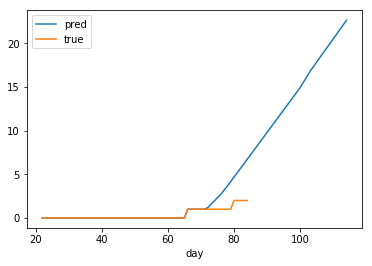

In [46]:
# Check the predictions of of Cases Public
place = 'Bhutan'
# place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>=72] = -1
df_interest['fatal/day'][df_interest['day']>=72] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>=72]
X_valid2 = df_interest[col_var2][df_interest['day']>=72]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>=72] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>=72] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model.predict(X_valid)
    pred_c = model2.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
        'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['cases/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest8['ConfirmedCases'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest8['day'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [47]:
last_day_train = df_traintest8['day'][pd.isna(df_traintest8['ForecastId'])].max()
print(last_day_train)
df_tmp = df_traintest8[
    (pd.isna(df_traintest8['ForecastId'])) |
    ((df_traintest8['day']>last_day_train) & (pd.isna(df_traintest8['ForecastId'])==False))].reset_index(drop=True)
df_tmp = df_tmp.drop([
    'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
    'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)',
    'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
    'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                               ],  axis=1)
df_traintest10 = []
for i, place in enumerate(places[:]):
    df_tmp2 = df_tmp[df_tmp['place_id']==place].reset_index(drop=True)
    df_tmp2 = do_aggregations(df_tmp2)
    df_traintest10.append(df_tmp2)
df_traintest10 = pd.concat(df_traintest10).reset_index(drop=True)
df_traintest10[df_traintest10['day']>last_day_train-5].head(10)

84


,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,place_id,day,cases/day,fatal/day,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,restrictions,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,id,Country/Region_le,Province/State_le,cases/day_(1-1),cases/day_(1-7),cases/day_(8-14),cases/day_(15-21),fatal/day_(1-1),fatal/day_(1-7),fatal/day_(8-14),fatal/day_(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal
58,24.0,Afghanistan,2020-03-20,0.0,NaN,59.0,33.0,65.0,nan,Afghanistan,80,2.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,58,29,0,0.000000e+00,2.142857e+00,0.857143,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,25,6,0,0,0,0
59,24.0,Afghanistan,2020-03-21,0.0,NaN,60.0,33.0,65.0,nan,Afghanistan,81,0.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,59,29,0,2.000000e+00,2.428571e+00,0.857143,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,26,7,0,0,0,0
60,40.0,Afghanistan,2020-03-22,1.0,NaN,61.0,33.0,65.0,nan,Afghanistan,82,1.600000e+01,1.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,60,29,0,0.000000e+00,1.857143e+00,1.428571,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,27,8,0,0,0,0
61,40.0,Afghanistan,2020-03-23,1.0,NaN,62.0,33.0,65.0,nan,Afghanistan,83,0.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,61,29,0,1.600000e+01,3.428571e+00,1.714286,0.428571,1.000000e+00,1.428571e-01,0.0,0.0,28,9,0,1,0,0
62,74.0,Afghanistan,2020-03-24,1.0,NaN,63.0,33.0,65.0,nan,Afghanistan,84,3.400000e+01,0.000000e+

len train: 50, len prediction: 43
63 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 3. 3. 4. 4. 5.]
Morocco


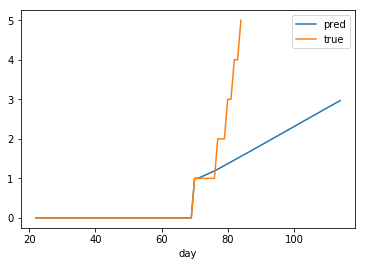

In [48]:
# Check the predictions of of Fatal Public
place = 'Sweden'
place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>=72] = -1
df_interest['fatal/day'][df_interest['day']>=72] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>=72]
X_valid2 = df_interest[col_var2][df_interest['day']>=72]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>=72] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>=72] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model.predict(X_valid)
    pred_c = model2.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
        'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['fatal/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest8['Fatalities'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest8['day'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

len train: 63, len prediction: 30
63 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   2.   3.   6.   6.  14.  26.  26.  33.  46.
  49.  67.  67.  84.  95. 116. 124.]
Cyprus


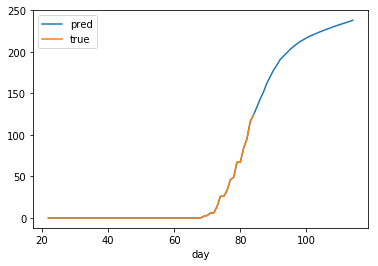

In [49]:
# Check the predictions of Cases Private
place = 'Bhutan'
place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest10[df_traintest10['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>last_day_train] = -1
df_interest['fatal/day'][df_interest['day']>last_day_train] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>84]
X_valid2 = df_interest[col_var2][df_interest['day']>84]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>last_day_train] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>last_day_train] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model_pri.predict(X_valid)
    pred_c = model2_pri.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
        'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['cases/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest10['ConfirmedCases'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest10['day'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

len train: 63, len prediction: 30
63 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
France/French Guiana


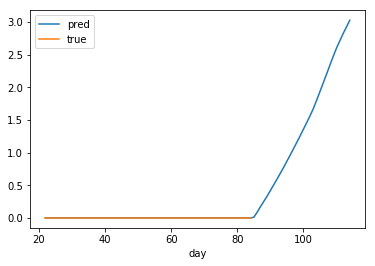

In [50]:
# Check the predictions of of Fatal Private
place = 'Bhutan'
place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest10[df_traintest10['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>last_day_train] = -1
df_interest['fatal/day'][df_interest['day']>last_day_train] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>84]
X_valid2 = df_interest[col_var2][df_interest['day']>84]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>last_day_train] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>last_day_train] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model_pri.predict(X_valid)
    pred_c = model2_pri.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
        'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['fatal/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest10['Fatalities'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest10['day'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

# Making submission

In [51]:
# predict test data in public
day_before_public = 71
df_preds = []
for i, place in enumerate(places[:]):
#     if place!='Japan' and place!='Afghanistan' :continue
    df_interest = copy.deepcopy(df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True))
    df_interest['cases/day'][(pd.isna(df_interest['ForecastId']))==False] = -1
    df_interest['fatal/day'][(pd.isna(df_interest['ForecastId']))==False] = -1
    len_known = (df_interest['day']<=day_before_public).sum()
    len_unknown = (day_before_public<df_interest['day']).sum()
    for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
        X_valid = df_interest[col_var].iloc[j+len_known]
        X_valid2 = df_interest[col_var2].iloc[j+len_known]
        pred_f = model.predict(X_valid)
        pred_c = model2.predict(X_valid2)
        pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
        pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
        df_interest['fatal/day'][j+len_known] = pred_f
        df_interest['cases/day'][j+len_known] = pred_c
        df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
        df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
        df_interest = df_interest.drop([
            'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
            'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)',
            'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
            'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',

                                       ],  axis=1)
        df_interest = do_aggregations(df_interest)
    if (i+1)%10==0:
        print("{:3d}/{}  {}, len known: {}, len unknown: {}".format(i+1, len(places), place, len_known, len_unknown), df_interest.shape)
    df_interest['fatal_pred'] = np.cumsum(df_interest['fatal/day'].values)
    df_interest['cases_pred'] = np.cumsum(df_interest['cases/day'].values)
    df_preds.append(df_interest)

 10/284  Australia/From Diamond Princess, len known: 50, len unknown: 43 (93, 83)
 20/284  Bahrain, len known: 50, len unknown: 43 (93, 83)
 30/284  Brunei, len known: 50, len unknown: 43 (93, 83)
 40/284  Canada/Newfoundland and Labrador, len known: 50, len unknown: 43 (93, 83)
 50/284  China/Chongqing, len known: 50, len unknown: 43 (93, 83)
 60/284  China/Hong Kong, len known: 50, len unknown: 43 (93, 83)
 70/284  China/Qinghai, len known: 50, len unknown: 43 (93, 83)
 80/284  China/Zhejiang, len known: 50, len unknown: 43 (93, 83)
 90/284  Czechia, len known: 50, len unknown: 43 (93, 83)
100/284  Ethiopia, len known: 50, len unknown: 43 (93, 83)
110/284  French Guiana, len known: 50, len unknown: 43 (93, 83)
120/284  Guatemala, len known: 50, len unknown: 43 (93, 83)
130/284  Iran, len known: 50, len unknown: 43 (93, 83)
140/284  Kenya, len known: 50, len unknown: 43 (93, 83)
150/284  Luxembourg, len known: 50, len unknown: 43 (93, 83)
160/284  Monaco, len known: 50, len unknown: 4

In [52]:
# concat prediction
df_preds= pd.concat(df_preds)
df_preds = df_preds.sort_values('day')
col_tmp = ['place_id', 'ForecastId', 'day', 'cases/day', 'cases_pred', 'fatal/day', 'fatal_pred',]
df_preds[col_tmp][(df_preds['place_id']=='Afghanistan') & (df_preds['day']>75)].head(10)

,place_id,ForecastId,day,cases/day,cases_pred,fatal/day,fatal_pred
54,Afghanistan,5.0,76,0.745075,10.896075,0.047440,0.197177
55,Afghanistan,6.0,77,0.899145,11.795220,0.047440,0.244617
56,Afghanistan,7.0,78,0.899145,12.694366,0.047440,0.292057
57,Afghanistan,8.0,79,0.883257,13.577623,0.047440,0.339498
58,Afghanistan,9.0,80,0.883257,14.460879,0.054694,0.394192
59,Afghanistan,10.0,81,0.883257,15.344136,0.054694,0.448885
60,Afghanistan,11.0,82,0.883257,16.227393,0.054694,0.503579
61,Afghanistan,12.0,83,0.761893,16.989286,0.054694,0.558273
62,Afghanistan,13.0,84,0.761893,17.751179,0.054694,0.612967
63,Afghanistan,14.0,85,0.752130,18.503309,0.054694,0.667661


In [53]:
# predict test data in public
day_before_private = 84
df_preds_pri = []
for i, place in enumerate(places[:]):
#     if place!='Japan' and place!='Afghanistan' :continue
    df_interest = copy.deepcopy(df_traintest10[df_traintest10['place_id']==place].reset_index(drop=True))
    df_interest['cases/day'][(pd.isna(df_interest['ForecastId']))==False] = -1
    df_interest['fatal/day'][(pd.isna(df_interest['ForecastId']))==False] = -1
    len_known = (df_interest['day']<=day_before_private).sum()
    len_unknown = (day_before_private<df_interest['day']).sum()
    for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
        X_valid = df_interest[col_var].iloc[j+len_known]
        X_valid2 = df_interest[col_var2].iloc[j+len_known]
        pred_f = model_pri.predict(X_valid)
        pred_c = model2_pri.predict(X_valid2)
        pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
        pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
        df_interest['fatal/day'][j+len_known] = pred_f
        df_interest['cases/day'][j+len_known] = pred_c
        df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
        df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
        df_interest = df_interest.drop([
            'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
            'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)',
            'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
            'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',

                                       ],  axis=1)
        df_interest = do_aggregations(df_interest)
    if (i+1)%10==0:
        print("{:3d}/{}  {}, len known: {}, len unknown: {}".format(i+1, len(places), place, len_known, len_unknown), df_interest.shape)
    df_interest['fatal_pred'] = np.cumsum(df_interest['fatal/day'].values)
    df_interest['cases_pred'] = np.cumsum(df_interest['cases/day'].values)
    df_preds_pri.append(df_interest)

 10/284  Australia/From Diamond Princess, len known: 63, len unknown: 30 (93, 83)
 20/284  Bahrain, len known: 63, len unknown: 30 (93, 83)
 30/284  Brunei, len known: 63, len unknown: 30 (93, 83)
 40/284  Canada/Newfoundland and Labrador, len known: 63, len unknown: 30 (93, 83)
 50/284  China/Chongqing, len known: 63, len unknown: 30 (93, 83)
 60/284  China/Hong Kong, len known: 63, len unknown: 30 (93, 83)
 70/284  China/Qinghai, len known: 63, len unknown: 30 (93, 83)
 80/284  China/Zhejiang, len known: 63, len unknown: 30 (93, 83)
 90/284  Czechia, len known: 63, len unknown: 30 (93, 83)
100/284  Ethiopia, len known: 63, len unknown: 30 (93, 83)
110/284  French Guiana, len known: 63, len unknown: 30 (93, 83)
120/284  Guatemala, len known: 63, len unknown: 30 (93, 83)
130/284  Iran, len known: 63, len unknown: 30 (93, 83)
140/284  Kenya, len known: 63, len unknown: 30 (93, 83)
150/284  Luxembourg, len known: 63, len unknown: 30 (93, 83)
160/284  Monaco, len known: 63, len unknown: 3

In [54]:
# concat prediction
df_preds_pri= pd.concat(df_preds_pri)
df_preds_pri = df_preds_pri.sort_values('day')
col_tmp = ['place_id', 'ForecastId', 'Date', 'day', 'cases/day', 'cases_pred', 'fatal/day', 'fatal_pred',]
df_preds_pri[col_tmp][(df_preds_pri['place_id']=='Japan') & (df_preds_pri['day']>79)].head(10)

,place_id,ForecastId,Date,day,cases/day,cases_pred,fatal/day,fatal_pred
58,Japan,NaN,2020-03-20,80,39.000000,963.000000,4.000000,33.000000
59,Japan,NaN,2020-03-21,81,44.000000,1007.000000,2.000000,35.000000
60,Japan,NaN,2020-03-22,82,79.000000,1086.000000,5.000000,40.000000
61,Japan,NaN,2020-03-23,83,42.000000,1128.000000,2.000000,42.000000
62,Japan,NaN,2020-03-24,84,65.000000,1193.000000,1.000000,43.000000
63,Japan,5819.0,2020-03-25,85,24.091987,1217.091987,1.826848,44.826848
64,Japan,5820.0,2020-03-26,86,18.613334,1235.705321,2.094037,46.920885
65,Japan,5821.0,2020-03-27,87,15.452892,1251.158213,2.159299,49.080184
66,Japan,5822.0,2020-03-28,88,14.025195,1265.183408,1.812506,50.892690
67,Japan,5823.0,2020-03-29,89,14.587510,1279.770918,1.812506,52.705196


In [55]:
# merge 2 preds
df_preds[df_preds['day']>last_day_train] = df_preds_pri[df_preds['day']>last_day_train]

In [56]:
df_preds.to_csv("df_preds.csv", index=None)

In [57]:
# load sample submission
df_sub = pd.read_csv("../input/covid19-global-forecasting-week-1/submission.csv")
print(len(df_sub))
df_sub.head()

12212


,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


In [58]:
# merge prediction with sub
df_sub = pd.merge(df_sub, df_traintest3[['ForecastId', 'place_id', 'day']])
df_sub = pd.merge(df_sub, df_preds[['place_id', 'day', 'cases_pred', 'fatal_pred']], on=['place_id', 'day',], how='left')
df_sub.head(10)

,ForecastId,ConfirmedCases,Fatalities,place_id,day,cases_pred,fatal_pred
0,1,1,1,Afghanistan,72,7.813206,0.007415
1,2,1,1,Afghanistan,73,8.575712,0.054856
2,3,1,1,Afghanistan,74,9.363356,0.102296
3,4,1,1,Afghanistan,75,10.151000,0.149736
4,5,1,1,Afghanistan,76,10.896075,0.197177
5,6,1,1,Afghanistan,77,11.795220,0.244617
6,7,1,1,Afghanistan,78,12.694366,0.292057
7,8,1,1,Afghanistan,79,13.577623,0.339498
8,9,1,1,Afghanistan,80,14.460879,0.394192
9,10,1,1,Afghanistan,81,15.344136,0.448885


In [59]:
# save
df_sub['ConfirmedCases'] = df_sub['cases_pred']
df_sub['Fatalities'] = df_sub['fatal_pred']
df_sub = df_sub[['ForecastId', 'ConfirmedCases', 'Fatalities']]
df_sub.to_csv("submission.csv", index=None)
df_sub.head(10)

,ForecastId,ConfirmedCases,Fatalities
0,1,7.813206,0.007415
1,2,8.575712,0.054856
2,3,9.363356,0.102296
3,4,10.151000,0.149736
4,5,10.896075,0.197177
5,6,11.795220,0.244617
6,7,12.694366,0.292057
7,8,13.577623,0.339498
8,9,14.460879,0.394192
9,10,15.344136,0.448885
